We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [4]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [8]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [9]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


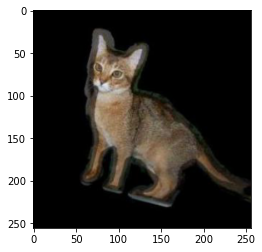

In [10]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model

In [11]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential(
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential(
                                    nn.Conv2d(in_channels=256, out_channels=300, kernel_size=3),
                                    nn.BatchNorm2d(300),
                                    nn.ReLU())
        
        self.conv8 = nn.Sequential(
                                    nn.Conv2d(in_channels=300, out_channels=370, kernel_size=3),
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(int(370*((size-240)/16)*((size-240)/16)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()


print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

# Training on a small batch

We shall now try to train the model above on a small batch obtained from each of the three training data sets that we have. If we are able to overtrain (achieve almost total training accuracy) on these small datasets, we'll go ahead and check if we can achieve very high training accuracy on the entire training sets.

In [11]:
# Trying to overtrain on a small batch from set r1

model1 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)


train_r1_loader_temp = DataLoader(train_r1,batch_size=512,shuffle=True)
x = next(iter(train_r1_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(140):
    model1.train()       # to set the model in training mode coz batchnorm will behave differently in the eval mode
    
    out = model1(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model1.eval()
        with torch.no_grad():
            out = model1(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))        # time taken for the last 20 iterations
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.6213059425354004
Accuracy:0.025390625
Time taken for the last 20 iterations: 102.0115385055542
Iteration:40
Loss:3.5569145679473877
Accuracy:0.05859375
Time taken for the last 20 iterations: 102.55926394462585
Iteration:60
Loss:0.7499175071716309
Accuracy:1.0
Time taken for the last 20 iterations: 102.24734425544739
Iteration:80
Loss:0.09408485889434814
Accuracy:1.0
Time taken for the last 20 iterations: 100.88192558288574
Iteration:100
Loss:0.05790691450238228
Accuracy:1.0
Time taken for the last 20 iterations: 99.59749603271484
Iteration:120
Loss:0.04520978033542633
Accuracy:1.0
Time taken for the last 20 iterations: 100.766352891922
Iteration:140
Loss:0.03719599172472954
Accuracy:1.0
Time taken for the last 20 iterations: 101.35267567634583


In [12]:
# Trying to overtrain on a small batch from set r2

model2 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(),lr=learning_rate)

train_r2_loader_temp = DataLoader(train_r2,batch_size=512,shuffle=True)
x = next(iter(train_r2_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(140):
    model2.train()
    
    out = model2(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model2.eval()
        with torch.no_grad():
            out = model2(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))      
                    
        start = time.time()      
       
        

    


Iteration:20
Loss:3.62066650390625
Accuracy:0.03515625
Time taken for the last 20 iterations: 91.12056112289429
Iteration:40
Loss:3.4358460903167725
Accuracy:0.07421875
Time taken for the last 20 iterations: 100.75129389762878
Iteration:60
Loss:0.3961680233478546
Accuracy:0.998046875
Time taken for the last 20 iterations: 100.22176313400269
Iteration:80
Loss:0.0905860885977745
Accuracy:1.0
Time taken for the last 20 iterations: 99.25989270210266
Iteration:100
Loss:0.06030166149139404
Accuracy:1.0
Time taken for the last 20 iterations: 100.15617561340332
Iteration:120
Loss:0.04706096276640892
Accuracy:1.0
Time taken for the last 20 iterations: 100.48230075836182
Iteration:140
Loss:0.03812294825911522
Accuracy:1.0
Time taken for the last 20 iterations: 99.71765613555908


In [13]:
# Trying to overtrain on a small batch from set r3

model3 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model3.parameters(),lr=learning_rate)

train_r3_loader_temp = DataLoader(train_r3,batch_size=512,shuffle=True)
x = next(iter(train_r3_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(140):
    model3.train()
    
    out = model3(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model3.eval()
        with torch.no_grad():
            out = model3(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))      
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.6263747215270996
Accuracy:0.03125
Time taken for the last 20 iterations: 85.89708304405212
Iteration:40
Loss:3.564344882965088
Accuracy:0.05078125
Time taken for the last 20 iterations: 102.10571122169495
Iteration:60
Loss:0.5015668272972107
Accuracy:1.0
Time taken for the last 20 iterations: 105.49361896514893
Iteration:80
Loss:0.08511313796043396
Accuracy:1.0
Time taken for the last 20 iterations: 104.16592526435852
Iteration:100
Loss:0.0561002753674984
Accuracy:1.0
Time taken for the last 20 iterations: 107.718665599823
Iteration:120
Loss:0.04422798380255699
Accuracy:1.0
Time taken for the last 20 iterations: 104.83716177940369
Iteration:140
Loss:0.036587055772542953
Accuracy:1.0
Time taken for the last 20 iterations: 105.38210868835449


# Training on the entire dataset

We shall now check if we can overtrain our models on the entire datasets.

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 28.258216381072998
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 31.099743366241455
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 30.464890718460083
Current training loss:2.889603853225708
Current training accuracy:0.25
Current validation loss:3.132214069366455
Current validation accuracy:0.1435278356075287
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 32.26071834564209
Current training loss:2.9581050872802734
Current training accuracy:0.21875
Current validation loss:3.0708727836608887
Current validation accuracy:0.16096580028533936
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 30.81009578704834
Current training loss:2.627490520477295
Current training accuracy:0.296875
Current validation loss:2.99831223487854
Current validation accuracy:0.1696847826242447
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 31.036314487457275
Current training loss:2.4723048210

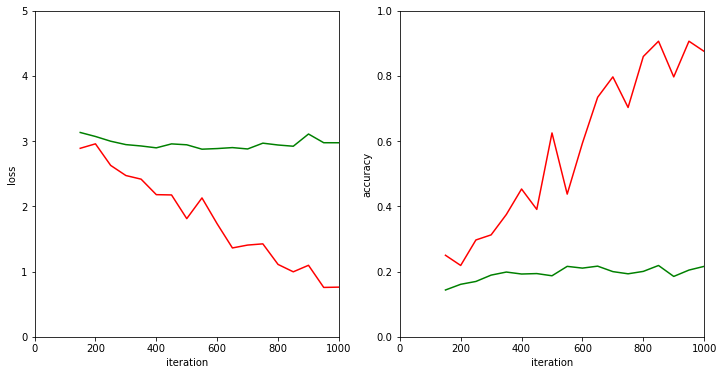

In [19]:
model1 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)

num_epochs = 10

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_out = model1(images.float())    # we're also calculating the training accuracy on the minibatches
                    current_train_loss = loss_function(train_out,labels)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels).sum()/64
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                
               
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,1000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,1000)
acc_graph.set_ylim(0,1)

plt.show()
            
        

    
